In [255]:
%matplotlib notebook  
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import data
from sklearn.preprocessing import StandardScaler
import talib
from btc_env import BitcoinEnv

<IPython.core.display.Javascript object>


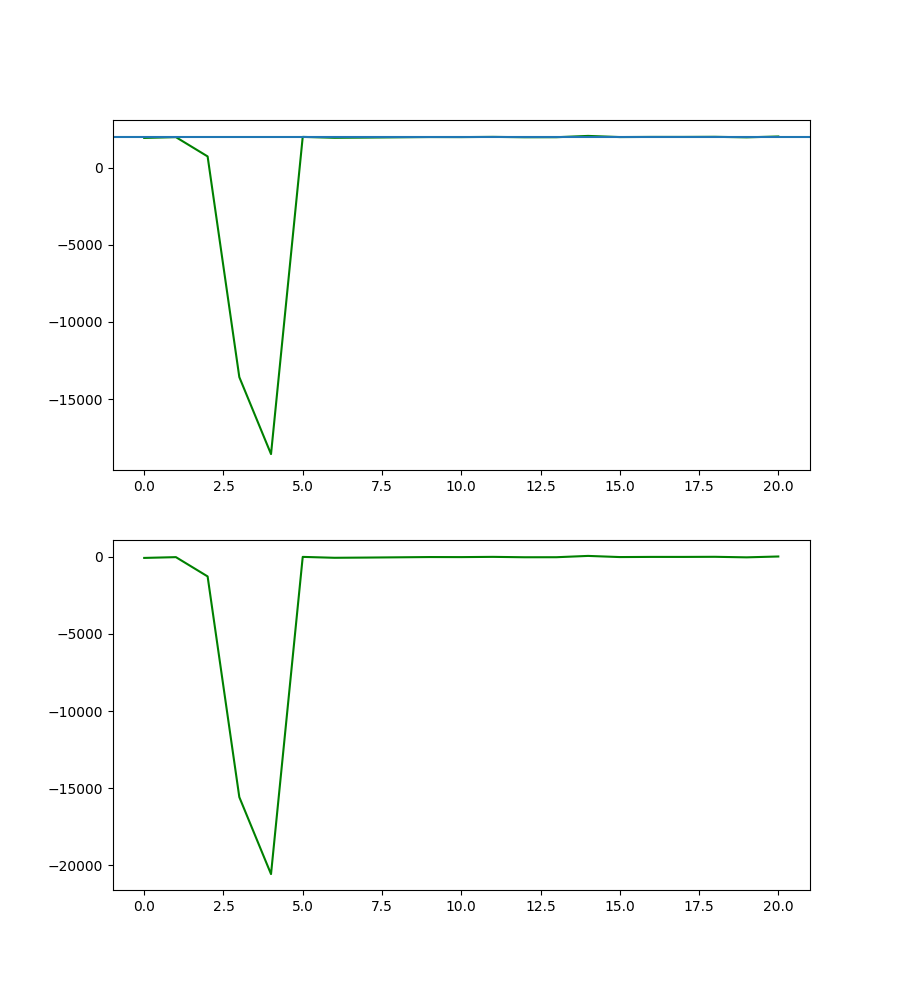

In [256]:
"""
Plot how these runs are doing. Run this cell each time you want to check
"""

d = dict(
    #y="PPOAgent|256", # baseline
    g="A3CAgent",
    #r="PPOAgent|elu-lstm",
    #b="PPOAgent|dropout.5",
    #m="PPOAgent|discount.97"
)

queries = {}
for k, v in d.items():
    queries[k] = """
    select reward, cash+value as total 
    from episodes 
    where agent_name='{}' 
    order by episode asc
    --limit 250
    --offset 10
    """.format(v)

fig = plt.figure(figsize=(9,10))
ax_total = fig.add_subplot(211)
ax_reward = fig.add_subplot(212)
#plt.ion()

fig.show()
fig.canvas.draw()

def prep(arr, period=None):
    if not period: return arr
    return [np.mean(arr[i-period:i]) for i,v in enumerate(arr)]
    #return talib.SMA(arr.values, timeperiod=period)
    
def draw():
    dfs = {}
    for k, v in queries.items(): 
        dfs[k] = pd.read_sql_query(v, data.conn)
    ax_total.clear(); ax_reward.clear()
    rewards, totals = [], []
    for k, v in dfs.items():
        rewards += [prep(v['reward']), k]  # [arr, 'b']
        totals += [prep(v['total']), k]
    ax_reward.plot(*rewards)
    ax_total.plot(*totals)
    ax_total.axhline(y=2000)
    #ax_total.set_ylim([1900,2100])
    fig.canvas.draw()
    #ax_reward.set_ylim([-3000000,1000])
    
draw()
#while True:
#    draw()

#    time.sleep(10)

episode 15


<IPython.core.display.Javascript object>


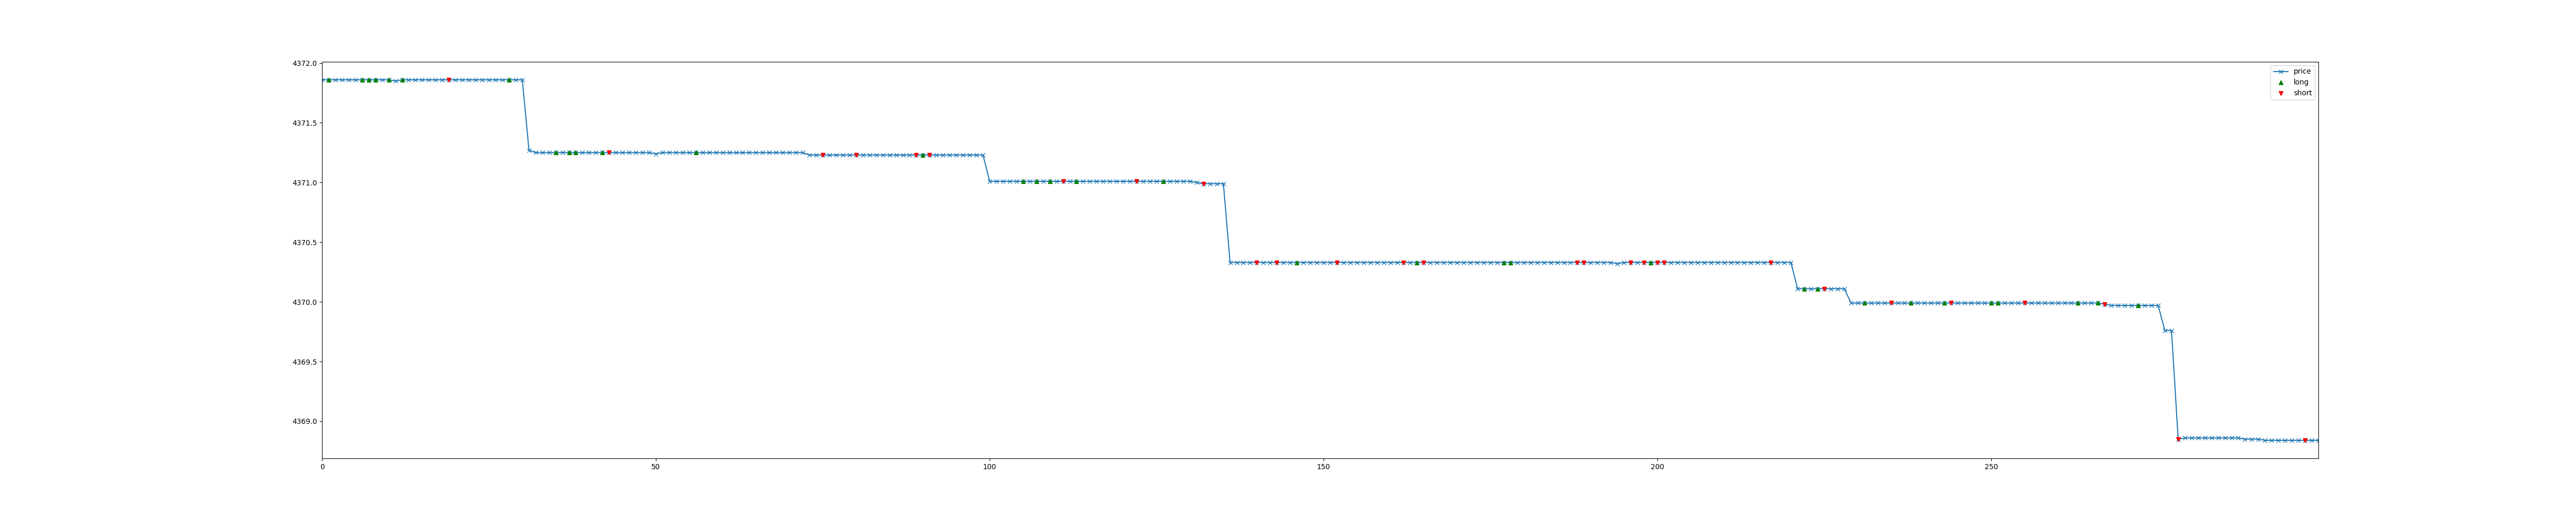

0      0.0
2      0.0
3      0.0
4      0.0
5      0.0
9      0.0
11     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19    -5.0
20     0.0
21     0.0
22     0.0
23     0.0
24     0.0
25     0.0
26     0.0
27     0.0
29     0.0
30     0.0
31     0.0
32     0.0
33     0.0
34     0.0
36     0.0
39     0.0
      ... 
269    0.0
270    0.0
271    0.0
273    0.0
274    0.0
275    0.0
276    0.0
277    0.0
278   -5.0
279    0.0
280    0.0
281    0.0
282    0.0
283    0.0
284    0.0
285    0.0
286    0.0
287    0.0
288    0.0
289    0.0
290    0.0
291    0.0
292    0.0
293    0.0
294    0.0
295    0.0
296    0.0
297   -5.0
298    0.0
299    0.0
Length: 267, dtype: float64


In [257]:
"""
Plot a sample of trades made by a successful run
"""
from matplotlib import cm
from tradingWithPython.lib.backtest import Backtest
rows = data.conn.execute("""
    select y, signals, episode from episodes 
    where agent_name='A3CAgent' and signals is not null 
    order by episode desc limit 1 offset 1
""").fetchall()
y, signals, ep = rows[0]
print('episode', ep)
p, signals = pd.Series(y[:300]), pd.Series(signals[:300])
fig = plt.figure(figsize=(50, 10))

print(signals[signals <= 0])

MIN = 1
l = ['price']    
p.plot(style='x-')
             
# # --- plot trades
# #colored line for long positions
idx = (signals > MIN)
if idx.any():
    p[idx].plot(style='g^')
    l.append('long')

# #colored line for short positions    
idx = (signals < -MIN)
if idx.any():
    p[idx].plot(style='rv')
    l.append('short')

plt.xlim([p.index[0],p.index[-1]]) # show full axis
plt.legend(l,loc='best')  

#print('PNL:{}'.format(bt.pnl.iloc[-1]))
#fig.canvas.draw()
plt.show()

In [249]:
"""
Again but with Backtrader https://www.backtrader.com/docu/quickstart/quickstart.html
"""
import backtrader as bt
rows = conn.execute("""
    select y, signals from episodes 
    where agent_name='A3C|VPG|D150L150L510' and signals is not null 
    order by episode desc limit 1
""").fetchall()
y, signals = rows[0]
i = 0
class TestStrategy(bt.Strategy):
    def next(self):
        global signals, i
        sig = signals[i]; i += 1
        if sig > 1: self.buy(sig)
        elif sig < 1: self.sell(sig)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(bt.feeds.PandasData(dataname=y))
cerebro.broker.setcash(2000) # set value somewhere?
cerebro.broker.setcommission(commission=.0025)
cerebro.run()

NameError: name 'conn' is not defined

In [ ]:
"""
Scratch-pad
"""
env = BitcoinEnv(agent_type='PPOAgent')
env.scale_features_and_save()

In [235]:
weights, n_picks = [.33, .33, .33], 2
t = np.cumsum(weights)
s = np.sum(weights)
np.searchsorted(t,np.random.rand(n_picks)*s)

array([0, 1])